In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import *
import numpy as np
import cv2
import torchvision.utils as vutils
from sklearn.preprocessing import OneHotEncoder
from skimage.segmentation import slic
from scipy import integrate
from torchvision import *
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/Computer Vision Project/office_31.tar.gz" './'
!tar xvzf office_31.tar.gz

In [3]:
!unzip -qq 'drive/MyDrive/Computer Vision Project/amazon_files.zip'
!unzip -qq 'drive/MyDrive/Computer Vision Project/webcam_files.zip'

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import *

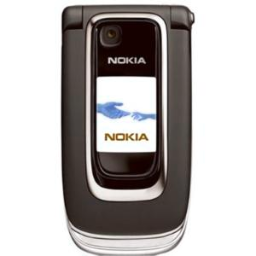

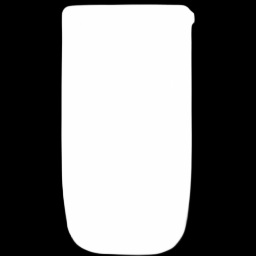

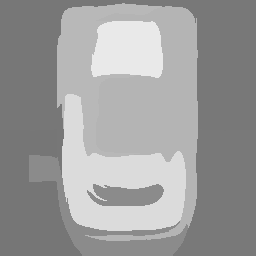

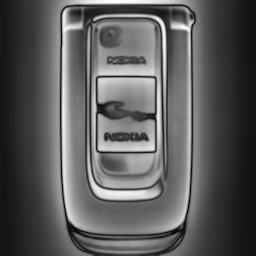

In [107]:
#image
cv2_imshow(torch.load('amazon_files/amazon_img/300.pt').numpy().transpose(1,2,0))
#SOTA saliency detector
cv2_imshow(cv2.imread('amazon_files/amazon_smaps/300.png',0))
#Co-saliency algorithm
cv2_imshow(torch.load('amazon_files/amazon_sal/300.pt').squeeze(dim=0).numpy()*255)
#cv2's saliency algorithm
sal = cv2.saliency.StaticSaliencyFineGrained_create()
cv2_imshow(sal.computeSaliency(torch.load('amazon_files/amazon_img/300.pt').numpy().transpose(1,2,0))[1]*255)

In [7]:
def make_map(original_image,image_label,superpixel_label,cluster_value):
    new_image = np.zeros_like(original_image,dtype=np.float)
    for i in range(new_image.shape[0]):
        for j in range(new_image.shape[1]):
            new_image[i][j]=cluster_value[superpixel_label[image_label[i][j]][0]]

    return new_image

def contrast_cue(center_array,label_array):
    total_pixels=label_array.shape[0]
    cue_array=[]
    for i in range(center_array.shape[0]):
        total_output=0
        for j in range(center_array.shape[0]):
            if (i!=j):
                result = np.where(label_array ==j)  
                num_pixels_j=result[0].shape[0]
                cluster_distance = np.sqrt(np.square((center_array[i]-center_array[j])[:3]).sum())
                total_output+=(cluster_distance*num_pixels_j/total_pixels)
        cue_array.append(total_output)
    return cue_array

def spatial_cue_xy(center,label_array,center_array,k_cluster):
    spatial_array=[]
    sigma_val = 0.4#(1/(2**0.5))**0.5
    for j in range(k_cluster):
        result = np.where(label_array ==j) 
        num_pixels_j=result[0].shape[0]
        total=0
        for i in range(center_array.shape[0]):    
            if (label_array[i]==j):  
                cluster_distance =((((center_array-center)**2).sum(axis=1))**0.5)[i]
                cluster_distance = np.exp(-0.5*np.square(cluster_distance/sigma_val))/(sigma_val*np.sqrt(2*3.14))
                total+=cluster_distance
        spatial_array.append(total/num_pixels_j)

    return spatial_array


def separation_measure(cue_map):
    gray_map = cue_map[:,:,0]
    gray_image = gray_map*255

    min = np.inf
    threshold = -1
    for i in range(1,256):
        before_num = (gray_image < i).sum()
        after_num = (gray_image >= i).sum()
        if(after_num==0):
            break
        before_tss = ((gray_image[gray_image < i]-gray_image[gray_image < i].mean())**2).sum()
        after_tss = ((gray_image[gray_image >= i]-gray_image[gray_image >= i].mean())**2).sum()

        curr_sum = before_tss + after_tss
        if(curr_sum<min):
            min = curr_sum
            threshold = i


    fg_pixels = np.where(gray_image>threshold)
    bg_pixels = np.where(gray_image<=threshold)

    foreground = gray_map[fg_pixels]
    background = gray_map[bg_pixels]

    fg_mean = foreground.mean()
    fg_std = foreground.std()

    bg_mean = background.mean()
    bg_std = background.std()

    z = ((bg_mean*(fg_std**2) - fg_mean*(bg_std**2))/(fg_std**2-bg_std**2)) + (fg_std*bg_std/(fg_std**2-bg_std**2)) * (((fg_mean-bg_mean)**2) - 2*(fg_std**2-bg_std**2)*(np.log(bg_std)-np.log(fg_std)))**0.5


    fg_integral = lambda z: np.exp(-((z-fg_mean)/fg_std)**2)/(fg_std*((2*np.pi)**0.5))
    bg_integral = lambda z: np.exp(-((z-bg_mean)/bg_std)**2)/(bg_std*((2*np.pi)**0.5))
    LS = integrate.quad(fg_integral, 0, z)[0] + integrate.quad(bg_integral, z, 1)[0]

    cue_weight = 1/(1+np.log10(1+256*LS))

    return cue_weight

def sal_func(img):
    M, N = img.shape[0],img.shape[1]
    segments = slic(img, n_segments = 100, sigma = 5)
    color_array=np.array([[0,0,0]]*(segments.max()+1),dtype=np.float)
    xy_array=np.array([[0,0]]*(segments.max()+1),dtype=np.float)
    r_min, r_max = img[:,:,0].min(), img[:,:,0].max()
    g_min, g_max = img[:,:,1].min(), img[:,:,1].max()
    b_min, b_max = img[:,:,2].min(), img[:,:,2].max()
    x_min, x_max = 0, M
    y_min, y_max = 0, N
    min1 = np.array([r_min,g_min,b_min,x_min,y_min])
    max1 = np.array([r_max,g_max,b_max,x_max,y_max])
    
    final = np.append(img, np.tile(np.arange(M).reshape(M,1), N).reshape(M,N,1), axis=-1)
    final = np.append(final, np.tile(np.arange(N).reshape(N,1), M).T.reshape(M,N,1), axis=-1)
    final = (final-min1)/(max1-min1)
    #Apply grayscale to final
    # final = cv2.cvtColor(final, cv2.COLOR_BGR2GRAY)
    # final=final*255

    
    for i in range(segments.max()+1):
        points = np.where(segments==i)
        xy_array[i] = np.array(points).mean(axis=1)
        xy_array[i] = (xy_array[i] - np.array([x_min,y_min]))/(np.array([x_max,y_max])-np.array([x_min,y_min]))
        color_array[i] = final[:,:,:3][points].mean(axis=0)

    rgbxy_array = np.append(color_array,xy_array,axis=-1)
    k_cluster = 80
    Z = np.float32(rgbxy_array)
    criteria = (cv2.TERM_CRITERIA_EPS, 10, 1.0)
    _,label,center=cv2.kmeans(Z,k_cluster,None,criteria,100,cv2.KMEANS_PP_CENTERS)
    contrast_cue_map = make_map(img,segments,label,contrast_cue(center,label))
    center = np.array([final[:,:,3][M//2][N//2],final[:,:,4][M//2][N//2]])
    spatial_cue_map = make_map(img,segments,label,np.array(spatial_cue_xy(center,label,rgbxy_array[:,-2:],k_cluster)))
    contrast_cue_weight = separation_measure(contrast_cue_map)
    spatial_cue_weight = separation_measure(spatial_cue_map)
    resultant_cue_map = ((contrast_cue_weight/(contrast_cue_weight+spatial_cue_weight))*contrast_cue_map) + ((spatial_cue_weight/(contrast_cue_weight+spatial_cue_weight))*spatial_cue_map)
    resultant_cue_map= resultant_cue_map.mean(axis=2)
    resultant_cue_map=resultant_cue_map*255
    resultant_cue_map=resultant_cue_map.astype('uint8')
    # th2,resultant_cue_map = cv2.threshold(resultant_cue_map,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    min = np.inf
    threshold = -1
    for i in range(1,256):
      before_tss = ((resultant_cue_map[resultant_cue_map < i]-resultant_cue_map[resultant_cue_map < i].mean())**2).sum()
      after_tss = ((resultant_cue_map[resultant_cue_map >= i]-resultant_cue_map[resultant_cue_map >= i].mean())**2).sum()

      curr_sum = before_tss + after_tss
      if (curr_sum<min):
        min = curr_sum
        threshold = i

    resultant_cue_map[resultant_cue_map<threshold] = 0
    resultant_cue_map[resultant_cue_map>=threshold] = 1
    

    return resultant_cue_map

In [23]:
class Data2(Dataset):
    def __init__(self,source,img_size,normalise=-1):
        
        self.size_img = img_size
        
        self.source = source+'_files/'+source
        

        self.images = sorted(os.listdir(self.source+'_img'))
        self.labels = sorted(os.listdir(self.source+'_label'))
        self.sal = sorted(os.listdir(self.source+'_smaps'))
        
        if(not self.images[0][0].isnumeric()):
          self.images = self.images[1:]
        
        if(not self.labels[0][0].isnumeric()):
          self.labels = self.labels[1:]

        if(not self.sal[0][0].isnumeric()):
          self.sal = self.sal[1:]

        print(self.images)
        print(self.labels)
        print(self.sal)
        
        #Standardisation
        self.mean_channels = np.zeros(3)
        self.std_channels = np.zeros(3)

        if(normalise!=-1):
          self.calc_scale_measures()
        
        else:
          self.mean_channels = np.zeros(3).reshape((3,1,1))
          self.std_channels = np.ones(3).reshape((3,1,1))


    def calc_scale_measures(self):
        path1, path2 = self.returnimages()

        for i in range(len(path2)):
          im = cv2.resize(cv2.imread(path1+path2[i][1]+'/'+path2[i][0]),(256,256))
          im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
          im = im.transpose(2,0,1) 
          self.mean_channels[0] += np.mean(im[0,:,:])/len(path2)
          self.mean_channels[1] += np.mean(im[1,:,:])/len(path2)
          self.mean_channels[2] += np.mean(im[2,:,:])/len(path2)
          self.std_channels[0] += np.std(im[0,:,:])/len(path2)
          self.std_channels[1] += np.std(im[1,:,:])/len(path2)
          self.std_channels[2] += np.std(im[2,:,:])/len(path2)

        self.mean_channels = self.mean_channels.reshape((3,1,1))
        self.std_channels = self.std_channels.reshape((3,1,1))


    def set_scale_measures(self, mean, std):
        self.mean_channels = mean
        self.std_channels = std
    
    def get_scale_measures(self):
        return self.mean_channels, self.std_channels

    def returnimages(self):
        path1 = self.file+'/'+self.source+'/images/'
        path2 = self.instances
        return path1, path2
    
    def __len__(self):
        return len(self.labels)
    

    def __getitem__(self,idx):
        
        s_img = torch.load(self.source+'_img/'+self.images[idx]).numpy().astype(np.float)
        
        sLabel = torch.load(self.source+'_label/'+self.labels[idx]).numpy().astype(np.float)
        
        s_smap = cv2.imread(self.source+'_smaps/'+self.sal[idx],0).astype(np.float)

        _, s_seg = cv2.threshold(s_smap, 0, 255, cv2.THRESH_BINARY)

        s_img = s_img/255
        s_smap = np.expand_dims(s_smap,axis=0)/255
        s_seg = np.expand_dims(s_seg,axis=0)/255

        #s_img = s_img*s_smap

        #s_img = np.concatenate([s_img,s_smap],axis=0)
        
        #s_img = np.concatenate([s_img,s_img*s_smap],axis=0)

        #s_img = (s_img - self.mean_channels)/self.std_channels
     
        #Slabel = np.zeros(31)
        #Slabel[int(sLabel)] = 1
        data = {'img': s_img , 'label':sLabel}
        return data

In [6]:
class AugmentedData2(Dataset):
    def __init__(self,source,target,img_size,normalise=-1):
        
        self.size_img = img_size
           
        
        self.source = source+'_files/'+source

        self.images = sorted(os.listdir(self.source+'_img'))
        self.labels = sorted(os.listdir(self.source+'_label'))
        self.sal = sorted(os.listdir(self.source+'_smaps'))
        
        if(not self.images[0][0].isnumeric()):
          self.images = self.images[1:]
        
        if(not self.labels[0][0].isnumeric()):
          self.labels = self.labels[1:]

        if(not self.sal[0][0].isnumeric()):
          self.sal = self.sal[1:]
        
        print(self.images)
        print(self.labels)
        print(self.sal)        


        self.target = target+'_files/'+target

        self.images_t = sorted(os.listdir(self.target+'_img'))
        self.labels_t = sorted(os.listdir(self.target+'_label'))
        self.sal_t = sorted(os.listdir(self.target+'_smaps'))
        
        if(not self.images_t[0][0].isnumeric()):
          self.images_t = self.images_t[1:]
        
        if(not self.labels_t[0][0].isnumeric()):
          self.labels_t = self.labels_t[1:]

        if(not self.sal_t[0][0].isnumeric()):
          self.sal_t = self.sal_t[1:]

        print(self.images_t)
        print(self.labels_t)
        print(self.sal_t)
        
        
        self.t_indices = np.random.choice(len(self.labels_t),len(self.labels_t)//10)

        #Standardisation
        self.mean_channels = np.zeros(3)
        self.std_channels = np.zeros(3)

        if(normalise!=-1):
          self.calc_scale_measures()
        
        else:
          self.mean_channels = np.zeros(3).reshape((3,1,1))
          self.std_channels = np.ones(3).reshape((3,1,1))


    def calc_scale_measures(self):
        path1, path2 = self.returnimages()

        for i in range(len(path2)):
          im = cv2.resize(cv2.imread(path1+path2[i][1]+'/'+path2[i][0]),(256,256))
          im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
          im = im.transpose(2,0,1) 
          self.mean_channels[0] += np.mean(im[0,:,:])/len(path2)
          self.mean_channels[1] += np.mean(im[1,:,:])/len(path2)
          self.mean_channels[2] += np.mean(im[2,:,:])/len(path2)
          self.std_channels[0] += np.std(im[0,:,:])/len(path2)
          self.std_channels[1] += np.std(im[1,:,:])/len(path2)
          self.std_channels[2] += np.std(im[2,:,:])/len(path2)

        self.mean_channels = self.mean_channels.reshape((3,1,1))
        self.std_channels = self.std_channels.reshape((3,1,1))


    def set_scale_measures(self, mean, std):
        self.mean_channels = mean
        self.std_channels = std
    
    def get_scale_measures(self):
        return self.mean_channels, self.std_channels

    def returnimages(self):
        path1 = self.file+'/'+self.source+'/images/'
        path2 = self.instances
        return path1, path2
    
    def __len__(self):
        return len(self.labels)*2
    

    def __getitem__(self,idx):

        s_idx = idx%len(self.labels)
        #t_idx = np.random.choice(len(self.labels_t),1)[0]
        t_idx = np.random.choice(self.t_indices,1)[0]

        s_img = torch.load(self.source+'_img/'+self.images[s_idx]).numpy().astype(np.float)
        
        sLabel = torch.load(self.source+'_label/'+self.labels[s_idx]).numpy().astype(np.float)
        
        s_smap = cv2.imread(self.source+'_smaps/'+self.sal[s_idx],0).astype(np.float)

        _, s_seg = cv2.threshold(s_smap, 0, 255, cv2.THRESH_BINARY)

        s_img = s_img/255
        s_smap = np.expand_dims(s_smap,axis=0)/255
        s_seg = np.expand_dims(s_seg,axis=0)/255


        t_img = torch.load(self.target+'_img/'+self.images_t[t_idx]).numpy().astype(np.float)
        
        tLabel = torch.load(self.target+'_label/'+self.labels_t[t_idx]).numpy().astype(np.float)

        t_smap = cv2.imread(self.target+'_smaps/'+self.sal_t[t_idx],0).astype(np.float)

        _, t_seg = cv2.threshold(t_smap, 0, 255, cv2.THRESH_BINARY)

        t_img = t_img/255
        t_smap = np.expand_dims(t_smap,axis=0)/255
        t_seg = np.expand_dims(t_seg,axis=0)/255


        #s_img = s_img*s_smap
        
        
        #t_img = t_img*(1-t_smap)
        
        
        factor = 0.75
        size = 256
        p1,p2 = self.salientPatchCorners(s_smap,factor*size)
        p3,p4 = self.salientPatchCorners(t_smap,factor*size)
        #t_img[:,p3[0]:p4[0],p3[1]:p4[1]] =  s_img[:,p1[0]:p2[0],p1[1]:p2[1]] 


        #t_img[:,p3[0]:p4[0],p3[1]:p4[1]]*(1-t_smap[:,p3[0]:p4[0],p3[1]:p4[1]]) +

        #Slabel = np.zeros(31)

        #Slabel[int(sLabel)] = s_samap.max()
        #Slabel[int(tLabel)] = 1-t_samap.max()


        #s_img = s_img*s_smap


        #s_img = s_img/255
        #s_smap = s_smap*255
        
        #s_img = np.concatenate([s_img,s_smap,s_samap],axis=0)
        
        if(np.random.uniform()>0.8):

          #t_img = np.concatenate([t_img,t_smap],axis=0)
          
          #t_img = t_img*t_smap
          
          s_img[:,p1[0]:p2[0],p1[1]:p2[1]] = t_img[:,p3[0]:p4[0],p3[1]:p4[1]]
          
          #t_img = t_img*t_smap + s_img*(1-s_smap)
          
          t_img = s_img
          sLabel = tLabel

        else:
          #t_img = np.concatenate([s_img,s_smap],axis=0)
          
          #s_img = s_img*s_smap
          
          t_img[:,p3[0]:p4[0],p3[1]:p4[1]] = s_img[:,p1[0]:p2[0],p1[1]:p2[1]]
          
          #t_img = s_img*s_smap + t_img*(1-t_smap)
        

        #t_img = np.concatenate([s_img,s_img*s_smap],axis=0)
        
        #s_img = (s_img - self.mean_channels)/self.std_channels
             

        data = {'img': t_img , 'label':sLabel}
        return data


    def salientPatchCorners(self,smap,psize):
        t = np.unravel_index(smap.argmax(),smap.shape)
#         f = 0.1; s = int(smap1.shape[0]*f)
        tx,ty = 0,0
        if t[0] - psize//2 < 0 :
            tx = t[0] - psize//2 
        elif t[0] + psize//2 > smap.shape[0]:
            tx = t[0] + psize//2 - smap.shape[0]
        if t[1] - psize//2 < 0 :
            ty = t[1] - psize//2 
        elif t[1] + psize//2 > smap.shape[1]:
            ty = t[1] + psize//2 - smap.shape[1]
        t = (t[0] - tx , t[1] - ty)
        p1 = (int(t[0] - psize//2) , int(t[1] - psize//2))
        p2 = (int(t[0] + psize//2) , int(t[1] + psize//2))
        
        return p1,p2

In [17]:
!git clone https://github.com/NathanUA/BASNet.git
!mkdir saved_models
!mkdir saved_models/basnet_bsi
!cp 'drive/MyDrive/Computer Vision Project/basnet.pth' './saved_models/basnet_bsi/basnet.pth'

In [13]:
!cp 'drive/MyDrive/Computer Vision Project/BASNet.zip' BASNet.zip
!unzip -qq BASNet.zip

In [ ]:
%cd ..
!zip -r BASNet.zip BASNet
!cp BASNet.zip 'drive/MyDrive/Computer Vision Project/BASNet.zip'

In [ ]:
%cd BASNet/
!python basnet_test.py

In [24]:
d = Data2('amazon',256)

trainloader = DataLoader(d,batch_size = 8,shuffle=True,drop_last=False)
print(len(d))

['0.pt', '1.pt', '10.pt', '100.pt', '1000.pt', '1001.pt', '1002.pt', '1003.pt', '1004.pt', '1005.pt', '1006.pt', '1007.pt', '1008.pt', '1009.pt', '101.pt', '1010.pt', '1011.pt', '1012.pt', '1013.pt', '1014.pt', '1015.pt', '1016.pt', '1017.pt', '1018.pt', '1019.pt', '102.pt', '1020.pt', '1021.pt', '1022.pt', '1023.pt', '1024.pt', '1025.pt', '1026.pt', '1027.pt', '1028.pt', '1029.pt', '103.pt', '1030.pt', '1031.pt', '1032.pt', '1033.pt', '1034.pt', '1035.pt', '1036.pt', '1037.pt', '1038.pt', '1039.pt', '104.pt', '1040.pt', '1041.pt', '1042.pt', '1043.pt', '1044.pt', '1045.pt', '1046.pt', '1047.pt', '1048.pt', '1049.pt', '105.pt', '1050.pt', '1051.pt', '1052.pt', '1053.pt', '1054.pt', '1055.pt', '1056.pt', '1057.pt', '1058.pt', '1059.pt', '106.pt', '1060.pt', '1061.pt', '1062.pt', '1063.pt', '1064.pt', '1065.pt', '1066.pt', '1067.pt', '1068.pt', '1069.pt', '107.pt', '1070.pt', '1071.pt', '1072.pt', '1073.pt', '1074.pt', '1075.pt', '1076.pt', '1077.pt', '1078.pt', '1079.pt', '108.pt', '108

In [25]:
t_d = Data2('webcam',256)

testloader = DataLoader(t_d,batch_size = 8,shuffle=True,drop_last=False)
print(len(t_d))

['0.pt', '1.pt', '10.pt', '100.pt', '101.pt', '102.pt', '103.pt', '104.pt', '105.pt', '106.pt', '107.pt', '108.pt', '109.pt', '11.pt', '110.pt', '111.pt', '112.pt', '113.pt', '114.pt', '115.pt', '116.pt', '117.pt', '118.pt', '119.pt', '12.pt', '120.pt', '121.pt', '122.pt', '123.pt', '124.pt', '125.pt', '126.pt', '127.pt', '128.pt', '129.pt', '13.pt', '130.pt', '131.pt', '132.pt', '133.pt', '134.pt', '135.pt', '136.pt', '137.pt', '138.pt', '139.pt', '14.pt', '140.pt', '141.pt', '142.pt', '143.pt', '144.pt', '145.pt', '146.pt', '147.pt', '148.pt', '149.pt', '15.pt', '150.pt', '151.pt', '152.pt', '153.pt', '154.pt', '155.pt', '156.pt', '157.pt', '158.pt', '159.pt', '16.pt', '160.pt', '161.pt', '162.pt', '163.pt', '164.pt', '165.pt', '166.pt', '167.pt', '168.pt', '169.pt', '17.pt', '170.pt', '171.pt', '172.pt', '173.pt', '174.pt', '175.pt', '176.pt', '177.pt', '178.pt', '179.pt', '18.pt', '180.pt', '181.pt', '182.pt', '183.pt', '184.pt', '185.pt', '186.pt', '187.pt', '188.pt', '189.pt', '1

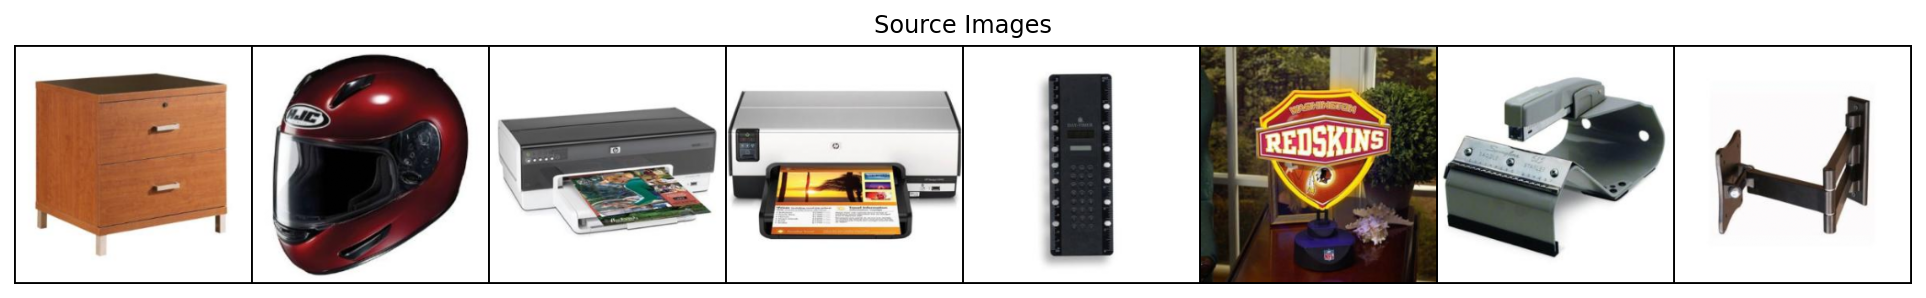

In [27]:
real_batch = next(iter(trainloader))
plt.figure(figsize=(17,17))
plt.axis("off")
plt.title("Source Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch['img'][:8], padding=2, normalize=True),(1,2,0)))
plt.show()

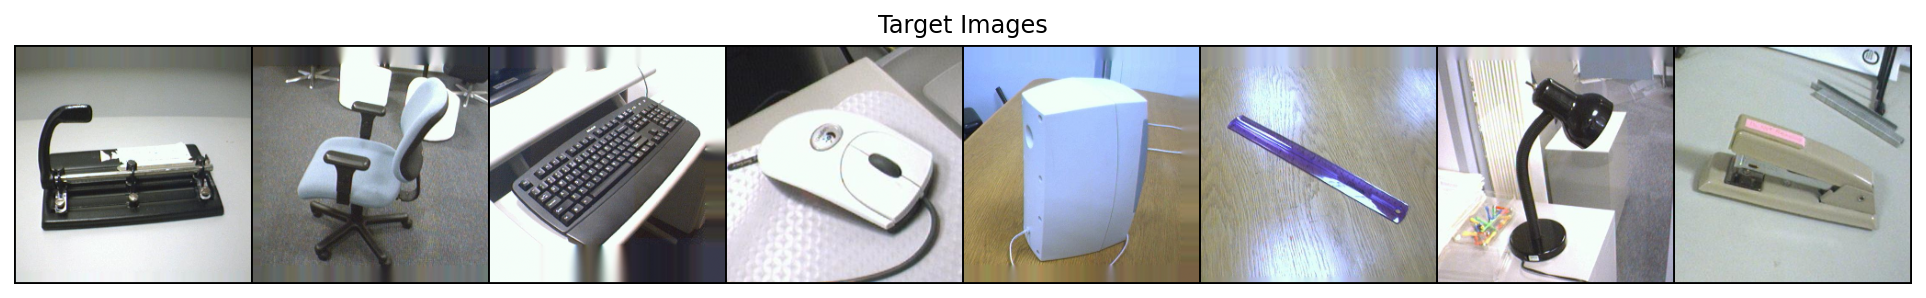

In [29]:
real_batch = next(iter(testloader))
plt.figure(figsize=(17,17))
plt.axis("off")
plt.title("Target Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch['img'][:8], padding=2, normalize=True),(1,2,0)))
plt.show()

In [572]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = torchvision.models.resnet18(pretrained=True)
net = net.to(device) 

#net.conv1 = nn.Conv2d(in_channels=1,out_channels=64,kernel_size=(7,7),stride=(2,2),padding=(3,3),bias=False).cuda()

In [573]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()


num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 31)
net.fc = net.fc.to(device)
#net.load_state_dict(torch.load('drive/MyDrive/CV_Project/resnet.pt'))

criterion = nn.CrossEntropyLoss()
#criterion = nn.KLDivLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [574]:
n_epochs = 3
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(trainloader)
total_step_test = len(testloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, data in enumerate(trainloader):
        #print(batch_idx)
        data_=data["img"]
        target_=data["label"]
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        target_=target_.long()
        data_=data_.float()
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {train_loss[-1]:.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data in (testloader):
            data_t=data["img"]
            target_t=data["label"]
            data_t, target_t = data_t.to(device), target_t.to(device)
            target_t=target_t.long()
            data_t=data_t.float()
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(testloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {val_loss[-1]:.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/3], Step [0/705], Loss: 3.6685
Epoch [1/3], Step [100/705], Loss: 2.2757
Epoch [1/3], Step [200/705], Loss: 1.6400
Epoch [1/3], Step [300/705], Loss: 1.6375
Epoch [1/3], Step [400/705], Loss: 0.2389
Epoch [1/3], Step [500/705], Loss: 0.4228
Epoch [1/3], Step [600/705], Loss: 0.7609
Epoch [1/3], Step [700/705], Loss: 0.4151

train-loss: 1.2187, train-acc: 72.7547
validation loss: 2.2499, validation acc: 44.0252

Improvement-Detected, save-model
Epoch 2

Epoch [2/3], Step [0/705], Loss: 0.4498
Epoch [2/3], Step [100/705], Loss: 0.2073
Epoch [2/3], Step [200/705], Loss: 0.1858
Epoch [2/3], Step [300/705], Loss: 0.4185
Epoch [2/3], Step [400/705], Loss: 0.0968
Epoch [2/3], Step [500/705], Loss: 0.0538
Epoch [2/3], Step [600/705], Loss: 0.5462
Epoch [2/3], Step [700/705], Loss: 0.0553

train-loss: 0.3168, train-acc: 93.1487
validation loss: 2.6036, validation acc: 38.3648

Epoch 3

Epoch [3/3], Step [0/705], Loss: 0.0601
Epoch [3/3], Step [100/705], Loss: 0.1559
Epoch [3/3

In [ ]:
batch_loss = 0
total_t=0
correct_t=0
with torch.no_grad():
    net.eval()
    for data in (testloader):
        data_t=data["img"]
        target_t=data["label"]
        data_t, target_t = data_t.to(device), target_t.to(device)
        target_t=target_t.long()
        data_t=data_t.float()
        outputs_t = net(data_t)
        loss_t = criterion(outputs_t, target_t)
        batch_loss += loss_t.item()
        _,pred_t = torch.max(outputs_t, dim=1)
        correct_t += torch.sum(pred_t==target_t).item()
        total_t += target_t.size(0)
        # print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        print("loss ",loss_t)
    val_acc.append(100 * correct_t/total_t)
    val_loss.append(batch_loss/len(testloader))
    network_learned = batch_loss < valid_loss_min
    print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

    
    if network_learned:
        valid_loss_min = batch_loss
        torch.save(net.state_dict(), 'resnet.pt')
        print('Improvement-Detected, save-model')